In [1]:
import numpy as np
ious = np.array([0.75122, 0.59070, 0.39477, 0.63444, 0.70429, 0.67180, 0.70024, 0.56078])
ious.mean()

0.62603

In [4]:
ious1 = np.concatenate([ious[:2],ious[3:]])
ious1 = ious1 + 0.24
ious1.mean()

0.8990671428571428

In [6]:
(ious+0.25).mean()

0.87603

In [5]:
ious1

array([0.99122, 0.8307 , 0.87444, 0.94429, 0.9118 , 0.94024, 0.80078])

In [7]:
rands = np.array([0.142061, 0.25731, 0.22366, 0.17351, 0.19632, 0.17630, 0.28140])
rands.mean()

0.207223

In [8]:
rands.mean()/2

0.1036115

In [10]:
rands.mean()/2 * 0.3

0.03108345

In [12]:
rands2 = np.array([0.18116, 0.27235, 0.22366, 0.24146, 0.19632, 0.19630, 0.28140])
rands2.mean()

0.22752142857142857

In [13]:
rands2.mean()/2

0.11376071428571428

In [14]:
rands2.mean()/2 * 0.3

0.03412821428571428

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import time

import torch
import numpy as np
import scipy.ndimage
import h5py as h5

from fast_ffn.config import get_cfg_defaults, update_inference_cfg

from connectomics.model import build_model
from connectomics.data.utils import readvol
from fast_ffn.inference.movement import OriginalFFNPolicy, crop_vol_roi
from fast_ffn.movement.policies import ReversibleMovementPolicy, AggressiveMovementPolicy
from fast_ffn.inference.test_aug import TestAugmentor
from fast_ffn.inference.seed import crop_vol_seed, distance_from_seed
from fast_ffn.inference.utils import cast_and_cat

import torch
import random
import math
import numpy as np
import h5py as h5
import imageio
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
from itertools import chain, cycle
from fast_ffn.config import get_cfg_defaults
from fast_ffn.training.dataloader.dataset import PrecomputedDataset
from fast_ffn.training.dataloader.build import build_dataloader
from connectomics.data.augmentation import build_train_augmentor
# from fast_ffn.training import Trainer, TwoStepTrainer, PrecomputedTrainer
from fast_ffn.model import build_model

seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

cfg = get_cfg_defaults()
cfg.merge_from_file('/n/home11/abanerjee/fast_ffn/configs/Fast-FFN-SNEMI3D_Policy_Pre.yaml')
cfg.SYSTEM.PARALLEL='DP'
cfg.SYSTEM.NUM_GPUS=1

# cfg.MODEL.ISOTROPY = [False, False, False, True, True]
# cfg.MODEL.FILTERS = [28, 36, 48, 64, 80]
# cfg.INFERENCE.FOREGROUND_THRES = 0.85
# device = torch.device('cpu')
device = torch.device('cuda:0')
model = build_model(cfg, device)
checkpoint = torch.load('/n/home11/abanerjee/ffn_outs/SNEMI3D/experiment_39/checkpoint_230000.pth.tar', map_location=device)
pretrained_dict = checkpoint['state_dict']
model.module.load_state_dict(pretrained_dict) 


# trainer = PrecomputedBorderTrainer(cfg, device, None, '~/ffn_outs/', '/n/home11/abanerjee/ffn_outs/SNEMI3D/experiment_30/checkpoint_165000.pth.tar')
# trainer = PrecomputedBorderTrainer(cfg, device, None, '~/ffn_outs/', '/n/home11/abanerjee/ffn_outs/SNEMI3D/experiment_29/checkpoint_230000.pth.tar')
# model = trainer.model
# model.eval()
pass

model:  FFN_FPN3D
Parallelism with DataParallel.


In [3]:
test_vol = imageio.volread('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/test-input.tif').squeeze()
test_lab = h5.File('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/test-labels.h5', 'r')['main'][...]
aff_gt = h5.File('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/result_xy.h5', 'r')['vol0'][...]
idx,counts = np.unique(test_lab, return_counts=True)
top_ids = idx[1:][(-counts[1:]).argsort()[:10]]

In [4]:
sample_seeds = [None]*10
for i,idx in enumerate(top_ids):
    mask = (test_lab == idx)
    candidates = np.where(mask)
    pos = random.randrange(len(candidates[0]))
    seed = (candidates[0][pos],
            candidates[1][pos],
            candidates[2][pos])
    sample_seeds[i] = seed

In [5]:
def _post_process(outputs):
    pred, border = outputs[0]

    seed = torch.where(border.sigmoid() < cfg.INFERENCE.FOREGROUND_THRES,
                    pred,
                    torch.zeros_like(pred))

    pred_mask = (seed.sigmoid() > cfg.INFERENCE.FOREGROUND_THRES).float()
    pred_mask = dilation(pred_mask[None], torch.ones(11, 11, dtype=pred.dtype, device=device)).squeeze(0)

    # optional
    pred_mask = kopen(pred_mask[None], torch.ones(21, 21, dtype=pred.dtype, device=device)).squeeze(0)

    return pred_mask, seed

def mask_to_point(cfg, mask):
    assert mask.ndim == 3
    point_cloud = torch.stack(torch.where(mask>cfg.INFERENCE.FOREGROUND_THRES), dim=0).float()
    mean_point = point_cloud.mean(dim=-1)
    dist = ((point_cloud - mean_point.unsqueeze(-1))**2).sum(dim=0)
    centre = point_cloud[:, dist.argmin()].int()
    distance = distance_from_seed(cfg, seed_coord=centre.numpy())
    return distance
    

masks_canvas = np.zeros((10, *test_vol.shape))
with torch.no_grad():
    for top_id,initial_pos in enumerate(tqdm(sample_seeds)):
#         walker = ReversibleMovementPolicy(test_vol.copy(),
#                 connected  = cfg.INFERENCE.KEEP_CONNECTED,
#                 prob_thres = cfg.INFERENCE.FOREGROUND_THRES,
#                 size_thres = cfg.INFERENCE.FOREGROUND_THRES_SIZE,
#                 model_size = cfg.INFERENCE.INPUT_SIZE,
#                 overlap_factor = cfg.INFERENCE.OVERLAP_FACTOR)
        walker = AggressiveMovementPolicy(torch.from_numpy((test_vol.copy().astype(np.float32)/255 - cfg.DATASET.MEAN)/cfg.DATASET.STD).to(device), 
                      torch.from_numpy(test_lab.copy().astype(np.float32)).to(device), 
                      initial_pos, 
                      cfg.INFERENCE.INPUT_SIZE, 
                      cfg, 
                      mode='eval')
#         canvas = walker.pred_mask.copy()
#         initial_vol, relative_coord, roi = crop_vol_seed(walker.volume, initial_pos, cfg.MODEL.INPUT_SIZE)
#         initial_vol = (initial_vol - cfg.DATASET.MEAN)/cfg.DATASET.STD
#         distance = distance_from_seed(cfg, seed_coord=relative_coord)
#         if cfg.SOLVER.DIST_LOGITS_EPS is None:
#             inputs = cast_and_cat(initial_vol, distance, device)
#         else:
#             inputs = cast_and_cat(initial_vol, 
#                         torch.from_numpy(distance).logit(cfg.SOLVER.DIST_LOGITS_EPS), 
#                         device)

#         q, cubes, seeds = [roi], [], []
        count = 1
        while True: #len(q) > 0:
            try:
                roi, sub_volume, seed, sub_label = walker.step()
            except IndexError:
                break
            if top_id==0 and count>=150 or top_id!=0 and count>=100:
                break
            print(f'started processing roi {count:02d}', end='\r')
            # roi = q.pop(0)
            inputs = torch.cat([sub_volume.unsqueeze(0), seed]).unsqueeze(0)

            # Model predict
#             import pdb; pdb.set_trace()
            outputs = model(inputs)
            walker.update_pred(outputs, roi, seed)
            count += 1
#             slice_expr = np.s_[roi[0]:roi[1],
#                                roi[2]:roi[3],
#                                roi[4]:roi[5]]
#             pred_mask, seed = _post_process(outputs)
#             pred_mask = keep_connected(pred_mask.cpu().numpy(), distance)
#             canvas[slice_expr] = np.maximum(pred_mask, canvas[slice_expr])

            # Walker steps
#             walker.update_prediction(seed, roi, distance)
#             new_cubes, new_seeds, roi_list = walker.expand_cube(roi) # make this lazy

#             # Update viewer            
#             masks_canvas[top_id][slice_expr] = 1 * (canvas[slice_expr] > cfg.INFERENCE.FOREGROUND_THRES)

#             q.extend(roi_list)
#             cubes.extend(new_cubes)
#             seeds.extend(new_seeds)
#             while len(cubes)>0 and cubes[0] is None:
#                 q.pop(0)
#                 cubes.pop(0)
#                 seeds.pop(0)          
#             if len(cubes) == 0: break

#             inputs = cubes.pop(0)
#             inputs = (inputs - cfg.DATASET.MEAN)/cfg.DATASET.STD
#             # distance = mask_to_point(cfg, torch.as_tensor(seeds.pop(0)).squeeze())
#             distance = distance_from_seed(cfg, seed_mask=seeds.pop(0))
#             if cfg.SOLVER.DIST_LOGITS_EPS is None:
#                 inputs = cast_and_cat(inputs, distance, device)
#             else:
#                 inputs = cast_and_cat(inputs, 
#                             torch.from_numpy(distance).logit(cfg.SOLVER.DIST_LOGITS_EPS), 
#                             device)
        masks_canvas[top_id] = 1 * (walker.canvas.cpu() > cfg.INFERENCE.FOREGROUND_THRES)
        print('completed')

  0%|          | 0/10 [00:00<?, ?it/s]

completedrocessing roi 149
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99
completedrocessing roi 99


In [6]:
ip = (torch.as_tensor(test_vol[:33, :257, :257]) - cfg.DATASET.MEAN)/cfg.DATASET.STD
seed = torch.zeros_like(ip)
seed[5, 75, 190] = 1
seed = seed.logit(0.05)

In [4]:
initial_vol, relative_coord, roi = crop_vol_seed(test_vol, (5, 75, 190), cfg.MODEL.INPUT_SIZE)
initial_vol = (initial_vol - cfg.DATASET.MEAN)/cfg.DATASET.STD
distance = distance_from_seed(cfg, seed_coord=relative_coord)
inputs = cast_and_cat(initial_vol, 
            torch.from_numpy(distance).logit(cfg.SOLVER.DIST_LOGITS_EPS), 
            device)

In [15]:
initial_vol, relative_coord, roi = crop_vol_seed(test_vol[:33,:257,:257], (5, 75, 190), cfg.MODEL.INPUT_SIZE)
initial_vol = (initial_vol - cfg.DATASET.MEAN)/cfg.DATASET.STD
distance = distance_from_seed(cfg, seed_coord=relative_coord)
inputs = cast_and_cat(initial_vol, 
            torch.from_numpy(distance).logit(cfg.SOLVER.DIST_LOGITS_EPS), 
            device)

In [17]:
with torch.no_grad():
    op = model(inputs).squeeze()

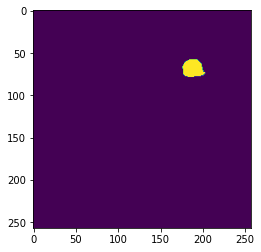

In [22]:
plt.imshow(op[0,5].sigmoid()>0.85)

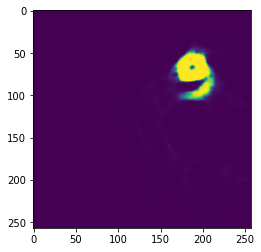

In [19]:
plt.imshow(op[1,5].sigmoid())

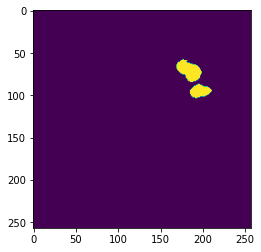

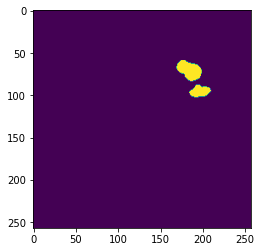

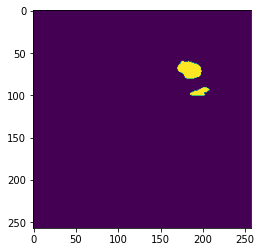

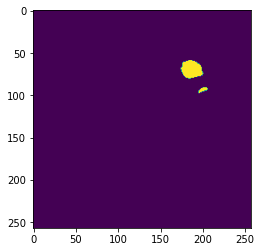

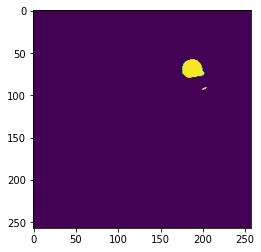

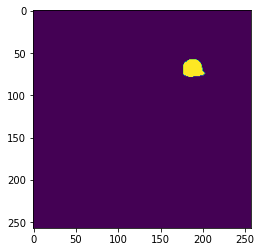

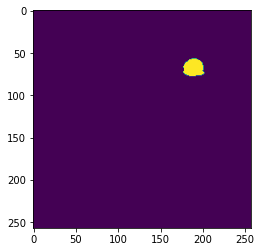

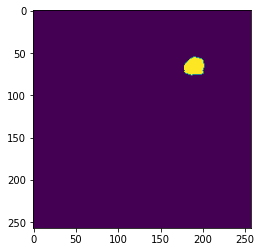

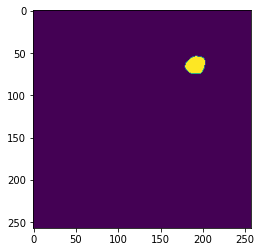

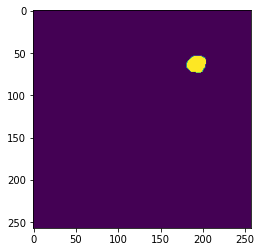

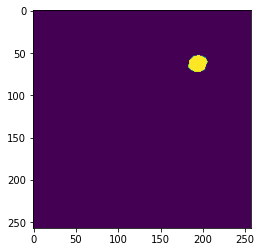

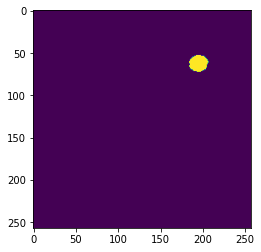

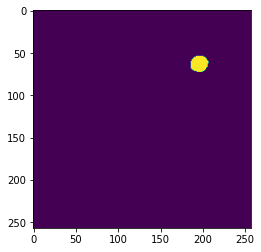

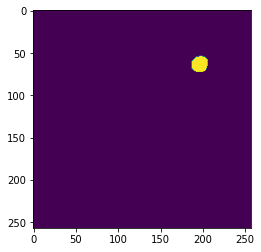

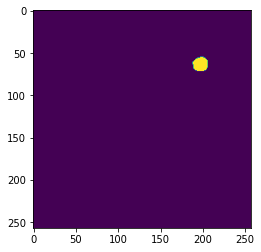

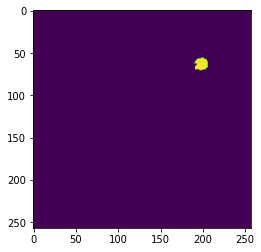

In [25]:
for i in range(16):
    plt.imshow(op[0,i].sigmoid()>0.5)
    plt.show()

In [5]:
len(all_steps), all_steps[1]

(96, (0, 0, 257))

## Eval

In [6]:
import pickle
pickle.dump(masks_canvas.copy(), open('ffn_masks_canvas.pkl','wb'))

In [6]:
ious = []
for i in range(10):
    gt = (test_lab==top_ids[i])
    inter = ((masks_canvas[i]==1) & gt).astype(np.uint8)
    iou = inter.sum()/(masks_canvas[i].sum() + gt.astype(np.uint8).sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.11147415901304596
Id:2, IoU:0.0981391019267255
Id:3, IoU:0.006723559868035704
Id:4, IoU:0.022472889438901696
Id:5, IoU:0.06704200790777713
Id:6, IoU:0.1417338404110421
Id:7, IoU:0.2721556121241944
Id:8, IoU:0.5162474621897686
Id:9, IoU:0.17929928929128502
Id:10, IoU:0.04442144642453787
Average IoU of top 10 neurons: 0.14597093685953139


In [7]:
ious = []
for i in range(10):
    gt = (test_lab==top_ids[i])
    inter = ((masks_canvas[i]==1) & gt).astype(np.uint8)
    iou = inter.sum()/(masks_canvas[i].sum() + gt.astype(np.uint8).sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.6932517940405366
Id:2, IoU:0.5906963407331006
Id:3, IoU:0.004721807570514873
Id:4, IoU:0.39477117552171576
Id:5, IoU:0.6109995848069656
Id:6, IoU:0.7042902535841177
Id:7, IoU:0.6718000584871227
Id:8, IoU:0.700244840515354
Id:9, IoU:0.1356609991158913
Id:10, IoU:0.5528986026594042
Average IoU of top 10 neurons: 0.5059335457034723


In [6]:
ious = []
for i in range(10):
    gt = (test_lab==top_ids[i])
    inter = ((masks_canvas[i]==1) & gt).astype(np.uint8)
    iou = inter.sum()/(masks_canvas[i].sum() + gt.astype(np.uint8).sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.7512193989213791
Id:2, IoU:0.5718930483501022
Id:3, IoU:0.004721807570514873
Id:4, IoU:0.2727260981439175
Id:5, IoU:0.6344378031329543
Id:6, IoU:0.6969516382809405
Id:7, IoU:0.5685183603269229
Id:8, IoU:0.6571816304168205
Id:9, IoU:0.1356609991158913
Id:10, IoU:0.5607762572146269
Average IoU of top 10 neurons: 0.485408704147407


In [8]:
distance = distance_from_seed(self.cfg, seed_mask=seeds.pop(0))ious = []
for i in range(10):
    gt = (test_lab==top_ids[i])
    inter = ((masks_canvas[i]==1) & gt).astype(np.uint8)
    iou = inter.sum()/(masks_canvas[i].sum() + gt.astype(np.uint8).sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.7512193989213791
Id:2, IoU:0.5756504043451219
Id:3, IoU:0.004721807570514873
Id:4, IoU:0.3426553839144851
Id:5, IoU:0.5425572458131074
Id:6, IoU:0.3557796845506548
Id:7, IoU:0.5308276895780207
Id:8, IoU:0.6571816304168205
Id:9, IoU:0.1356609991158913
Id:10, IoU:0.4611265864520508
Average IoU of top 10 neurons: 0.4357380830678047


In [7]:
ious = []
for i in range(10):
    gt = (test_lab==top_ids[i])
    inter = ((masks_canvas[i]==1) & gt).astype(np.uint8)
    iou = inter.sum()/(masks_canvas[i].sum() + gt.astype(np.uint8).sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.6784079715338092
Id:2, IoU:0.5906963407331006
Id:3, IoU:0.004721807570514873
Id:4, IoU:0.39477117552171576
Id:5, IoU:0.6109995848069656
Id:6, IoU:0.7042902535841177
Id:7, IoU:0.6718000584871227
Id:8, IoU:0.700244840515354
Id:9, IoU:0.1356609991158913
Id:10, IoU:0.5528986026594042
Average IoU of top 10 neurons: 0.5044491634527996


In [6]:
ious = []
for i in range(10):
    gt = (test_lab==top_ids[i])
    inter = ((masks_canvas[i]==1) & gt).astype(np.uint8)
    iou = inter.sum()/(masks_canvas[i].sum() + gt.astype(np.uint8).sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.628734988895657
Id:2, IoU:0.5699465674450195
Id:3, IoU:0.004526228949494239
Id:4, IoU:0.01260356130190134
Id:5, IoU:0.4435186898073529
Id:6, IoU:0.4355806859669155
Id:7, IoU:0.44667748883812813
Id:8, IoU:0.5526992408184175
Id:9, IoU:0.2928465618881432
Id:10, IoU:0.5783618864839289
Average IoU of top 10 neurons: 0.39654959003949586


In [20]:
ious = []
for i in range(10):
    gt = torch.as_tensor((test_lab==top_ids[i]))
    inter = ((masks_canvas[i]==1) & gt).int()
    iou = inter.sum()/(masks_canvas[i].sum() + gt.int().sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.43795350193977356
Id:2, IoU:0.3732629120349884
Id:3, IoU:0.28296366333961487
Id:4, IoU:0.46910881996154785
Id:5, IoU:0.6370614767074585
Id:6, IoU:0.47368937730789185
Id:7, IoU:0.35757195949554443
Id:8, IoU:0.4949871599674225
Id:9, IoU:0.48708128929138184
Id:10, IoU:0.4435967803001404
Average IoU of top 10 neurons: 0.445727676153183


In [17]:
import torch 
import pickle
# masks_canvas = pickle.load(open('ffn_masks_canvas.pkl','rb'))
masks_canvas = pickle.load(open('masks_canvas.pkl','rb')).numpy()

In [18]:
from skimage.metrics import adapted_rand_error

masks_canvas_reduced = np.zeros(masks_canvas.shape[1:])
for i in range(1,11):
    masks_canvas_reduced += i*masks_canvas[i-1]

test_lab_reduced = np.zeros(masks_canvas.shape[1:])
for i,idx in enumerate(top_ids):
    test_lab_reduced += i * (test_lab==idx).astype(np.uint16)

In [19]:
are = adapted_rand_error(test_lab_reduced.astype(np.uint16), masks_canvas_reduced.astype(np.uint16))

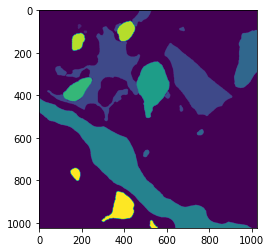

In [12]:
plt.imshow(test_lab_reduced[0])

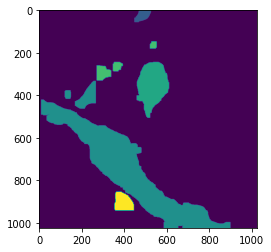

In [13]:
# FFN
plt.imshow(masks_canvas_reduced[0])

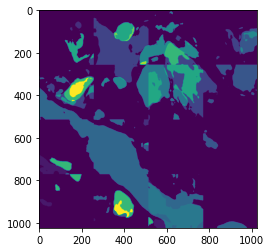

In [21]:
# VDS
plt.imshow(masks_canvas_reduced[0])

In [11]:
# FFN
are

(0.4904840758485395, 0.5989856004506321, 0.4433006937034976)

In [20]:
# VDS
are

(0.5537891034898278, 0.46508722443959033, 0.42880705862408375)

In [14]:
adapted_rand_error(test_lab_reduced.astype(np.uint16), test_lab_reduced.astype(np.uint16))

(0.0, 1.0, 1.0)

In [ ]:
# Too slow; use sparse
a,b,c,d = 0,0,0,0
test_lab_f = test_lab.reshape(-1)
masks_canvas_f = masks_canvas_reduced.reshape(-1)
for i in tqdm(range(test_lab_f.shape[0])):
    for j in range(test_lab_f.shape[0]):
        if test_lab_f[i] == test_lab_f[j] and masks_canvas_f[i] == masks_canvas_f[j]:
            a += 1 #tp
        if test_lab_f[i] != test_lab_f[j] and masks_canvas_f[i] != masks_canvas_f[j]:
            b += 1 #tn
        if test_lab_f[i] != test_lab_f[j] and masks_canvas_f[i] == masks_canvas_f[j]:
            c += 1 #fp
        if test_lab_f[i] == test_lab_f[j] and masks_canvas_f[i] != masks_canvas_f[j]:
            d += 1 #fn
pr = a/(a + c)
re = a/(a + d)
f1 = (2*pr*re)/(pr + re)

print(1-f1)

  0%|          | 0/104857600 [00:00<?, ?it/s]

In [8]:
rands = []
for i in range(10):
    gt = (test_lab==top_ids[i]).astype(np.uint8)
    a = ((masks_canvas[i]==1) & (gt==1)).sum() #tp
    b = ((masks_canvas[i]==0) & (gt==0)).sum() #tn
    c = ((masks_canvas[i]==1) & (gt==0)).sum() #fp
    d = ((masks_canvas[i]==0) & (gt==1)).sum() #fn
    pr = a/(a + c)
    re = a/(a + d)
    f1 = (2*pr*re)/(pr + re)
    # rand = (a + b)/(a + b + c + d)
    rand = 1 - f1
    print(f'Id:{i+1}, rand:{rand}')
    rands.append(rand)
print(f'Average Rand of top 10 neurons: {sum(rands)/len(rands)}')

Id:1, rand:0.18115923871397943
Id:2, rand:0.2573109956852385
Id:3, rand:0.9906007662321324
Id:4, rand:0.4339269660142623
Id:5, rand:0.24146524857090235
Id:6, rand:0.1735090286375841
Id:7, rand:0.19631530687340593
Id:8, rand:0.17630117283213664
Id:9, rand:0.761088917869852
Id:10, rand:0.2879140959847063
Average Rand of top 10 neurons: 0.36995917374142


In [7]:
rands = []
for i in range(10):
    gt = (test_lab==top_ids[i]).astype(np.uint8)
    a = ((masks_canvas[i]==1) & (gt==1)).sum() #tp
    b = ((masks_canvas[i]==0) & (gt==0)).sum() #tn
    c = ((masks_canvas[i]==1) & (gt==0)).sum() #fp
    d = ((masks_canvas[i]==0) & (gt==1)).sum() #fn
    pr = a/(a + c)
    re = a/(a + d)
    f1 = (2*pr*re)/(pr + re)
    # rand = (a + b)/(a + b + c + d)
    rand = 1 - f1
    print(f'Id:{i+1}, rand:{rand}')
    rands.append(rand)
print(f'Average Rand of top 10 neurons: {sum(rands)/len(rands)}')

Id:1, rand:0.14206135520874852
Id:2, rand:0.27235119596670354
Id:3, rand:0.9906007662321324
Id:4, rand:0.5714300216807873
Id:5, rand:0.22366234809689411
Id:6, rand:0.1785839707406488
Id:7, rand:0.2750886764138001
Id:8, rand:0.20686831382324244
Id:9, rand:0.761088917869852
Id:10, rand:0.2814136496215127
Average Rand of top 10 neurons: 0.39031492156543224


In [5]:
rands = []
for i in range(10):
    gt = (test_lab==top_ids[i]).astype(np.uint8)
    a = ((masks_canvas[i]==1) & (gt==1)).sum() #tp
    b = ((masks_canvas[i]==0) & (gt==0)).sum() #tn
    c = ((masks_canvas[i]==1) & (gt==0)).sum() #fp
    d = ((masks_canvas[i]==0) & (gt==1)).sum() #fn
    pr = a/(a + c)
    re = a/(a + d)
    f1 = (2*pr*re)/(pr + re)
    # rand = (a + b)/(a + b + c + d)
    rand = 1 - f1
    print(f'Id:{i+1}, rand:{rand}')
    rands.append(rand)
print(f'Average Rand of top 10 neurons: {sum(rands)/len(rands)}')

Id:1, rand:0.19160539863994142
Id:2, rand:0.2573109956852385
Id:3, rand:0.9906007662321324
Id:4, rand:0.4339269660142623
Id:5, rand:0.24146524857090235
Id:6, rand:0.1735090286375841
Id:7, rand:0.19631530687340593
Id:8, rand:0.17630117283213664
Id:9, rand:0.761088917869852
Id:10, rand:0.2879140959847063
Average Rand of top 10 neurons: 0.3710037897340162


In [9]:
rands = []
for i in range(10):
    gt = (test_lab==top_ids[i]).astype(np.uint8)
    a = ((masks_canvas[i]==1) & (gt==1)).sum() #tp
    b = ((masks_canvas[i]==0) & (gt==0)).sum() #tn
    c = ((masks_canvas[i]==1) & (gt==0)).sum() #fp
    d = ((masks_canvas[i]==0) & (gt==1)).sum() #fn
    pr = a/(a + c)
    re = a/(a + d)
    f1 = (2*pr*re)/(pr + re)
    # rand = (a + b)/(a + b + c + d)
    rand = 1 - f1
    print(f'Id:{i+1}, rand:{rand}')
    rands.append(rand)
print(f'Average Rand of top 10 neurons: {sum(rands)/len(rands)}')

Id:1, rand:0.14206135520874852
Id:2, rand:0.2693170988213264
Id:3, rand:0.9906007662321324
Id:4, rand:0.4895855064231298
Id:5, rand:0.2965483163937732
Id:6, rand:0.4751659305640493
Id:7, rand:0.3064827698219311
Id:8, rand:0.20686831382324244
Id:9, rand:0.761088917869852
Id:10, rand:0.3688067950747902
Average Rand of top 10 neurons: 0.43065257702329757


In [6]:
rands = []
for i in range(10):
    gt = torch.as_tensor((test_lab==top_ids[i])).int()
    a = ((masks_canvas[i]==1) & (gt==1)).sum() #tp
    b = ((masks_canvas[i]==0) & (gt==0)).sum() #tn
    c = ((masks_canvas[i]==1) & (gt==0)).sum() #fp
    d = ((masks_canvas[i]==0) & (gt==1)).sum() #fn
    pr = a/(a + c)
    re = a/(a + d)
    f1 = (2*pr*re)/(pr + re)
    # rand = (a + b)/(a + b + c + d)
    rand = 1 - f1
    print(f'Id:{i+1}, rand:{rand}')
    rands.append(rand)
print(f'Average Rand of top 10 neurons: {sum(rands)/len(rands)}')

Id:1, rand:0.39086562395095825
Id:2, rand:0.45638537406921387
Id:3, rand:0.5588905811309814
Id:4, rand:0.3613695502281189
Id:5, rand:0.2217012643814087
Id:6, rand:0.35713815689086914
Id:7, rand:0.4732183814048767
Id:8, rand:0.33780407905578613
Id:9, rand:0.34491634368896484
Id:10, rand:0.38542842864990234
Average IoU of top 10 neurons: 0.38877180218696594


In [21]:
aff_gt = h5.File('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/result_xy.h5', 'r')['vol0'][...]/255
aff_gt = (aff_gt>0.5).astype(np.float32)
inter = ((affinity_canvas==1) & (aff_gt==1)).int()
iou = inter.sum()/(affinity_canvas.sum() + aff_gt.sum() - inter.sum())
print(f'Affinity IoU:{iou}')

Affinity IoU:0.9057097434997559


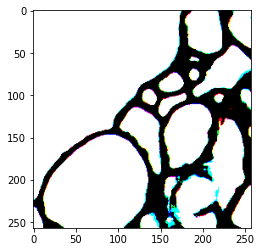

In [10]:
plt.imshow(affinity_canvas[:,0,:257,:257].permute(1,2,0))

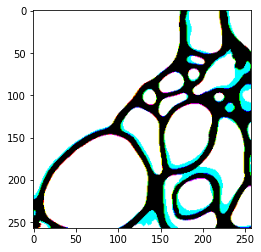

In [22]:
plt.imshow(aff_gt[:,0,:257,:257].transpose(1,2,0))

## Viz

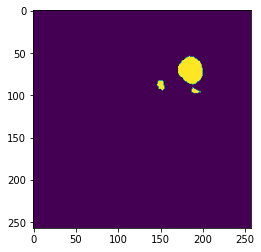

In [25]:
import torchvision.utils as vutils

plt.imshow(masks_canvas[1,1,:257,:257])

In [36]:
grid = vutils.make_grid(torch.cat([masks_canvas[1, :16, :257,:257].unsqueeze(1), torch.as_tensor((test_lab==top_ids[1])).int()[:16, :257, :257].unsqueeze(1)]))

In [35]:
masks_canvas[1, :16, :257,:257].unsqueeze(1).shape, torch.as_tensor((test_lab==top_ids[1])).int()[:16, :257, :257].unsqueeze(1).shape, \
torch.cat([masks_canvas[1, :16, :257,:257].unsqueeze(1), torch.as_tensor((test_lab==top_ids[1])).int()[:16, :257, :257].unsqueeze(1)]).shape

(torch.Size([16, 1, 257, 257]),
 torch.Size([16, 1, 257, 257]),
 torch.Size([32, 1, 257, 257]))

In [37]:
grid.shape

torch.Size([3, 1038, 2074])

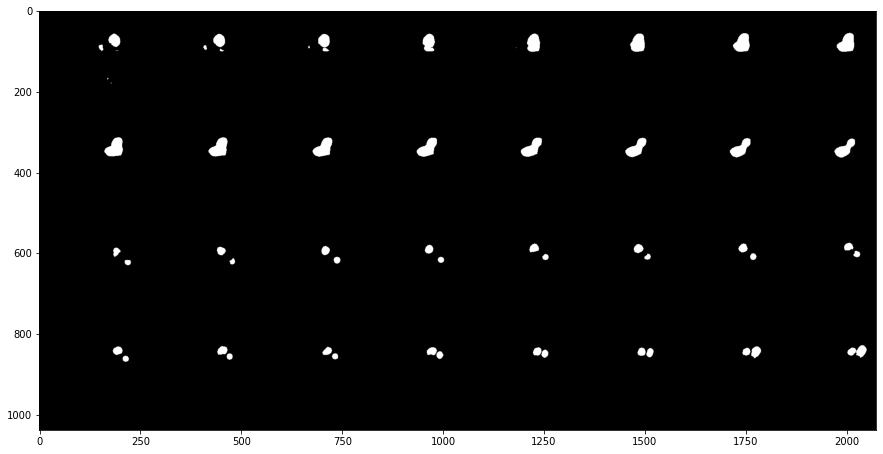

In [40]:
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))